In [1]:
import torch
import gpytorch
import transfer_opt
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from botorch.optim.fit import fit_gpytorch_scipy

In [3]:
%pdb

Automatic pdb calling has been turned ON


In [4]:
def gen_data(num_data, seed = 2019):
    torch.random.manual_seed(seed)
    
    x = torch.randn(num_data,1)
    y = torch.randn(num_data,1)
    
    u = torch.rand(1)
    data_fn = lambda x, y: 1 * torch.sin(0.25 * u * 3.1415 * (x + y)) + 1
    latent_fn = data_fn(x, y)
    z = torch.round(latent_fn).long().squeeze()
    return torch.cat((x,y),dim=1), z, data_fn
    

In [5]:
train_x, train_y, genfn = gen_data(1000)

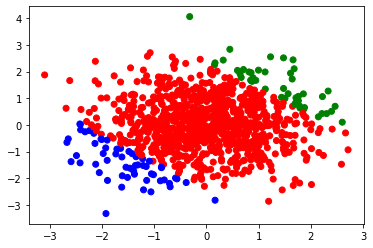

In [6]:
colors = np.array(['blue', 'red', 'green'])
plt.scatter(train_x[:,0].numpy(), train_x[:,1].numpy(), color = list(colors[train_y]))

In [7]:
test_d1 = np.linspace(-3, 3, 100)
test_d2 = np.linspace(-3, 3, 100)

test_x_mat, test_y_mat = np.meshgrid(test_d1, test_d2)
test_x_mat, test_y_mat = torch.Tensor(test_x_mat), torch.Tensor(test_y_mat)

test_x = torch.cat((test_x_mat.view(-1,1), test_y_mat.view(-1,1)),dim=1)
test_labels = torch.round(genfn(test_x_mat, test_y_mat))
test_y = test_labels.view(-1)

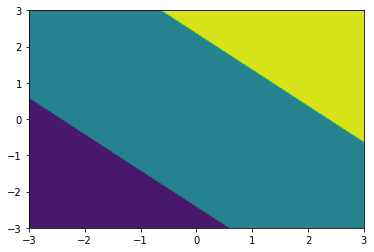

In [8]:
plt.contourf(test_x_mat.numpy(), test_y_mat.numpy(), test_labels.numpy())

In [9]:
class DPClassificationModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, alpha_epsilon = 0.01):
        num_classes = train_y.max() + 1
        
        # set alpha = \alpha_\epsilon
        alpha = alpha_epsilon * torch.ones(train_x.shape[-2], num_classes, 
                                           device = train_x.device, dtype = train_x.dtype)
        
        # alpha[class_labels] = 1 + \alpha_\epsilon
        alpha[torch.arange(len(train_x)), train_y] = alpha[torch.arange(len(train_x)), train_y] + 1.
        
        # sigma^2 = log(1 / alpha + 1)
        sigma2_i = torch.log(1 / alpha + 1.)
        
        # y = log(alpha) - 0.5 * sigma^2
        transformed_targets = alpha.log() - 0.5 * sigma2_i
        
        likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(sigma2_i.t(), learn_additional_noise= True)
        
        super(DPClassificationModel, self).__init__(train_x, transformed_targets.t(), likelihood)
        self.transformed_targets = transformed_targets
        
        self.mean_module = gpytorch.means.ConstantMean(batch_size = num_classes)
        self.covar_module = gpytorch.kernels.ScaleKernel(
                            gpytorch.kernels.RBFKernel(batch_size = num_classes, ard_num_dims = 2),
                            batch_size = num_classes)
        self.likelihood = likelihood
    
    def forward(self, x):
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

In [10]:
model = DPClassificationModel(train_x, train_y, alpha_epsilon = 0.1)

In [11]:
mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)

In [12]:
# Find optimal model hyperparameters
model.train()
model.likelihood.train()



FixedNoiseGaussianLikelihood(
  (quadrature): GaussHermiteQuadrature1D()
  (noise_covar): FixedGaussianNoise()
  (second_noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [13]:
fit = fit_gpytorch_scipy(mll)

In [14]:
# # Use the adam optimizer
# optimizer = torch.optim.Adam([
#     {'params': model.parameters()},  # Includes GaussianLikelihood parameters
# ], lr=0.1)

# training_iter = 500
# for i in range(training_iter):
#     # Zero gradients from previous iteration
#     optimizer.zero_grad()
#     # Output from model
#     output = model(train_x)
#     # Calc loss and backprop gradients
#     loss = -mll(output, model.transformed_targets.t()).sum()
#     loss.backward()
#     print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
#     optimizer.step()

In [15]:
gp_dist = model.likelihood(model(train_x))
torch_dist = torch.distributions.MultivariateNormal(gp_dist.mean, gp_dist.covariance_matrix)

In [16]:
exp_samples = torch.exp(torch_dist.rsample((5,)))
preds = exp_samples / exp_samples.sum(1, keepdim = True)

final_preds = preds.mean(0).max(0)[1]

In [17]:
torch.sum(final_preds == train_y)

tensor(505)

In [18]:
list(model.named_parameters())


[('likelihood.second_noise_covar.raw_noise', Parameter containing:
  tensor([-6.5258], requires_grad=True)),
 ('mean_module.constant', Parameter containing:
  tensor([[-2.7883],
          [-1.5572],
          [-2.9172]], requires_grad=True)),
 ('covar_module.raw_outputscale', Parameter containing:
  tensor([1.0563, 1.0988, 1.2124], requires_grad=True)),
 ('covar_module.base_kernel.raw_lengthscale', Parameter containing:
  tensor([[[0.4501, 0.6773]],
  
          [[0.5071, 0.5681]],
  
          [[0.5194, 0.3918]]], requires_grad=True))]

In [19]:
model.eval()
model.likelihood.eval()

FixedNoiseGaussianLikelihood(
  (quadrature): GaussHermiteQuadrature1D()
  (noise_covar): FixedGaussianNoise()
  (second_noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [20]:
with gpytorch.settings.fast_pred_var(), torch.no_grad():
    test_dist = model(test_x)
    
    pred_means = test_dist.loc
    pred_confs = test_dist.confidence_region()

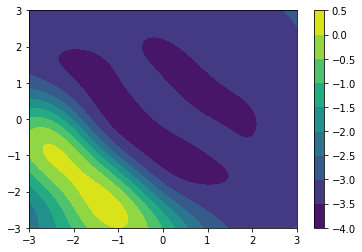

In [21]:
plt.contourf(test_x_mat.numpy(), test_y_mat.numpy(), pred_means[0].numpy().reshape((100,100)))
plt.colorbar()

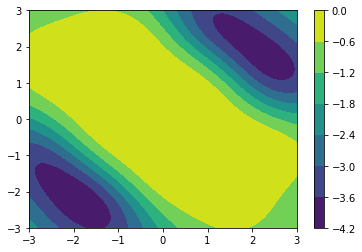

In [22]:
plt.contourf(test_x_mat.numpy(), test_y_mat.numpy(), pred_means[1].numpy().reshape((100,100)))
plt.colorbar()

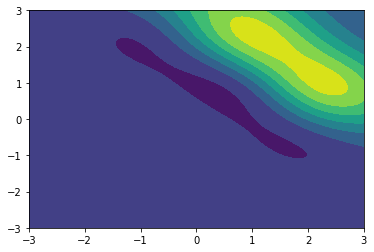

In [23]:
plt.contourf(test_x_mat.numpy(), test_y_mat.numpy(), pred_means[2].numpy().reshape((100,100)))


Text(0.5, 1.0, 'Estimated Response')

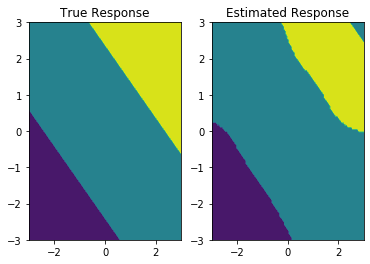

In [24]:
fig, ax = plt.subplots(1,2)

ax[0].contourf(test_x_mat.numpy(), test_y_mat.numpy(), test_labels.numpy())
ax[0].set_title('True Response')

ax[1].contourf(test_x_mat.numpy(), test_y_mat.numpy(), pred_means.max(0)[1].reshape((100,100)))
ax[1].set_title('Estimated Response')
